### Библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from tqdm import tqdm

import statsmodels.api as sm
from scipy.stats import t, f, boxcox, skew, kurtosis, gmean
from statsmodels.stats.diagnostic import linear_reset, het_white

import warnings
warnings.filterwarnings('ignore')

### Обработка

In [2]:
data = pd.read_csv('data_after_feature_selection.csv', encoding='utf-8')

### Логарифм цены

In [3]:
data['log_price'] = np.log(data['price'])
data = data.drop(['price'], axis=1)
y = data['log_price']
X = data.drop(['log_price'], axis=1)

In [5]:
def add_squared_terms(X, quantitative_vars):
    """
    Добавляет квадраты количественных переменных в DataFrame.

    Parameters:
    - X: pandas DataFrame, исходная матрица признаков
    - quantitative_vars: список количественных признаков, для которых нужно добавить квадраты

    Returns:
    - X с добавленными признаками-квадратами
    """
    for var in quantitative_vars:
        if var in X.columns:
            X[f"{var}_sq"] = X[var] ** 2
        else:
            raise ValueError(f"Признак '{var}' не найден в X")
    return X

In [6]:
quantitative_vars = ['avg_rating', 'tirage', 'cnt_reviews', 'pages_cnt']
X_new = add_squared_terms(X, quantitative_vars)

In [ ]:
log_model = sm.OLS(data['log_price'], X_new).fit()
y_pred = log_model.fittedvalues

In [14]:
ols_model = sm.OLS(data['log_price'], X_new).fit()

resid = ols_model.resid
y_pred = ols_model.fittedvalues

aux_model = sm.OLS(np.abs(resid), sm.add_constant(y_pred)).fit()

sigma_hat = aux_model.fittedvalues

y_transformed = y / sigma_hat
X_transformed = sm.add_constant(X).div(sigma_hat, axis=0)

wls_like_model = sm.OLS(y_transformed, X_transformed).fit()


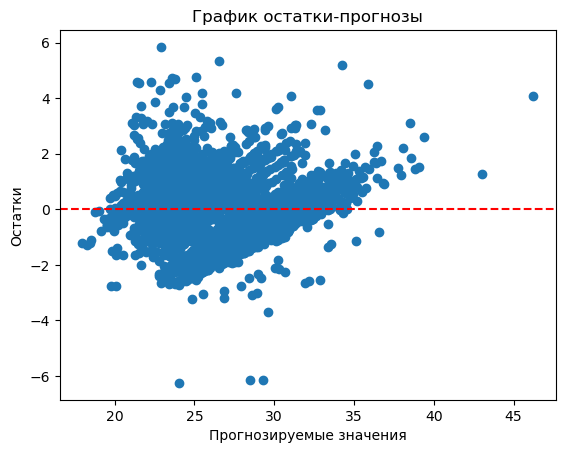

In [15]:
# Визуальный анализ
residuals_ln_y = wls_like_model.resid
fitted_values_ln_y = wls_like_model.fittedvalues

plt.scatter(fitted_values_ln_y, residuals_ln_y)
plt.axhline(0, color='red', linestyle='--')  # Прямая "остатки = 0"
plt.xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('График остатки-прогнозы')
plt.show()

In [17]:
X_transformed

,const,avg_rating,cnt_reviews,pages_cnt,tirage,publisher_АСТ,publisher_Азбука,publisher_Иностранка,publisher_Эксмо,cover_type_Мягкий_переплёт,2024_or_2025,6-,16+,avg_rating_sq,tirage_sq,cnt_reviews_sq,pages_cnt_sq
0,3.892292,15.958397,3600.370077,1992.853491,116768.759253,3.892292,0.0,0.000000,0.000000,3.892292,3.892292,0.0,3.892292,65.429428,3.503063e+09,3.330342e+06,1.020341e+06
1,3.973712,16.292217,5328.747160,1271.587689,119211.345852,3.973712,0.0,0.000000,0.000000,3.973712,3.973712,0.0,3.973712,66.798091,3.576340e+09,7.145850e+06,4.069081e+05
2,5.814249,26.164120,2110.572337,1116.335781,145356.221542,5.814249,0.0,0.000000,0.000000,5.814249,5.814249,0.0,5.814249,117.738539,3.633906e+09,7.661378e+05,2.143365e+05
3,4.903073,21.083212,4275.479342,1412.084920,58836.871673,4.903073,0.0,0.000000,0.000000,4.903073,4.903073,0.0,4.903073,90.657813,7.060425e+08,3.728218e+06,4.066805e+05
4,7.841552,32.934518,23556.022233,2509.296643,235246.560249,7.841552,0.0,0.000000,0.000000,7.841552,7.841552,0.0,7.841552,138.324977,7.057397e+09,7.076229e+07,8.029749e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,3.269021,16.345104,9.807062,2039.868933,4903.531089,0.000000,0.0,0.000000,3.269021,0.000000,0.000000,0.0,3.269021,81.725518,7.355297e+06,2.942119e+01,1.272878e+06
3186,3.633613,13.444368,192.581480,1627.858552,5450.419258,0.000000,0.0,0.000000,3.633613,0.000000,0.000000,0.0,3.633613,49.744160,8.175629e+06,1.020682e+04,7.292806e+05
3187,3.091479,13.293359,129.842116,2423.719493,9274.436836,0.000000,0.0,3.091479,0.000000,0.000000,0.000000,0.0,3.091479,57.161446,2.782331e+07,5.453369e+03,1.900196e+06
3188,3.476652,13.211276,100.822895,2447.562687,6953.303088,0.000000,0.0,0.000000,3.476652,0.000000,0.000000,0.0,3.476652,50.202848,1.390661e+07,2.923864e+03,1.723084e+06


In [18]:
# Тест Уайта
white_test = het_white(residuals_ln_y, X_transformed)

lm_stat, lm_pval, f_stat, f_pval = white_test

print(f"LM-статистика: {lm_stat}")
print(f"p-value для LM-статистики: {lm_pval}")
print(f"F-статистика: {f_stat}")
print(f"p-value для F-статистики: {f_pval}")

if lm_pval < 0.05:
    print("Гетероскедастичность выявлена.")
else:
    print("Нет признаков гетероскедастичности.")

ValueError: White's heteroskedasticity test requires exog to have at least two columns where one is a constant.

### Регрессоры, которые можно логарифмировать и нет

In [ ]:
cols_to_try_log = ['avg_rating', 'tirage', 'cnt_reviews', 'pages_cnt']
unconditional_cols = [x for x in X.columns.tolist() if x not in cols_to_try_log]

In [ ]:
def generate_all_combinations(num_of_repeats):
    """Генерирует все комбинации признаков, к которым применяется функциональное преобразование"""
    return product([False, True], repeat=num_of_repeats)

def prepare_X(cols_to_try_func, combination, df, func, flag='stay'):
    """Создает матрицу X для текущей комбинации"""
    """Примеры функций: np.log, np.power, np.reciprocal, ..."""
    X_temp = df[unconditional_cols].copy()
    feature_name = getattr(func, '__name__', repr(func))
    
    for i, col in enumerate(cols_to_try_func): # col = 'tirage'
        if combination[i]:
            try:
                safe_col = df[col]
                if (safe_col <= 0).any() and (func == np.log) or (func == np.reciprocal):
                    safe_col = safe_col + 1e-6
                if flag == 'stay':
                    X_temp[col] = safe_col
                    X_temp[f'{feature_name}_{col}'] = func(safe_col)
                else:
                    X_temp[f'{feature_name}_{col}'] = func(safe_col)
            except Exception as e:
                print(f"Ошибка при применении функции к {col}: {e}")
        else:
            X_temp[col] = df[col]
    
    return sm.add_constant(X_temp)

def getting_statistic(cols_to_try_func, df, func, flag='stay'):
    results = []

    total_combinations = 2 ** len(cols_to_try_func)
    feature_name = getattr(func, '__name__', repr(func))

    for combination in tqdm(generate_all_combinations(num_of_repeats=len(cols_to_try_func)), total=total_combinations):
        try:
            # Подготавливаем данные
            X_curr = prepare_X(cols_to_try_func, combination, df, func, flag=flag)

            model = sm.OLS(df['log_price'], X_curr).fit()
            results.append({
                'combination': combination,
                'aic': model.aic,
                'bic': model.bic,
                'adj_r2': model.rsquared_adj,
            })

        except Exception as e:
            print(f"Error in combination {combination}: {str(e)}")
            continue

    df_results = pd.DataFrame(results)

    df_results[f'{feature_name}_columns'] = df_results['combination'].apply(
        lambda x: [cols_to_try_func[i] for i, my_func in enumerate(x) if my_func]
    )
    
    return df_results

In [ ]:
def custom_func(x):
    return x**2

In [ ]:
data_frame = getting_statistic(cols_to_try_func=cols_to_try_log, df=data, func=custom_func, flag='stay')

best_aic = data_frame.loc[data_frame['aic'].idxmin()]
best_bic = data_frame.loc[data_frame['bic'].idxmin()]
best_adj_r2 = data_frame.loc[data_frame['adj_r2'].idxmax()]

print("Лучшая модель по AIC:")
print(f"Логарифмированные переменные: {best_aic[f'custom_func_columns']}")
print(f"AIC: {best_aic['aic']:.2f}\n")

print("Лучшая модель по BIC:")
print(f"Логарифмированные переменные: {best_bic[f'custom_func_columns']}")
print(f"BIC: {best_bic['bic']:.2f}\n")

print("Лучшая модель по Adj.R²:")
print(f"Логарифмированные переменные: {best_adj_r2[f'custom_func_columns']}")
print(f"Adj.R²: {best_adj_r2['adj_r2']:.4f}")

**Вывод:** нужно логарифмировать тираж; Adj R^2 = 0.6062

Зафискируем это:

In [ ]:
try_data = data.copy()
try_data['log_tirage'] = np.log(try_data['tirage'])
try_data = try_data.drop(['tirage'], axis=1)
try_data.head()

In [ ]:
X_try = try_data.drop(['log_price'], axis=1)

In [ ]:
cols_to_try_log_ = ['avg_rating', 'cnt_reviews', 'pages_cnt']
unconditional_cols_ = [x for x in X_try.columns.tolist() if x not in cols_to_try_log_]

Также функции будут работать, если мы решим проверить какие-то кастомные функции типо этого:

### Итоговая модель с ln Y

После проверки всех функциональных форм обучаем итоговую модель:

In [ ]:
cols_to_try_log

In [ ]:
cols_to_log = ['tirage']
cols_not_to_log = [col for col in cols_to_try_log if col not in cols_to_log] + unconditional_cols

X_log = np.log(data.loc[:, cols_to_log])
X_not_to_log = data.loc[:, cols_not_to_log]

X_log_model = sm.add_constant(pd.concat((X_log, X_not_to_log), axis=1))

log_model = sm.OLS(data['log_price'], X_log_model).fit()
log_model.summary()

In [ ]:
np.sum(log_model.resid**2)

**мини-вопрос на подумать:** допустим, мы попробовали разные функциональные формы для призаков и в качестве того, для чего резонно применять `log` и `custom_func` у нас функция выдала один и тот же признак `tirage`. Что с ним делать?
<br>
<br>
**"ответ":** я предлагаю сильно не заморачиваться и выбрать что придется

In [ ]:
# def delete_outliers_iof(data, target):
#     df = data.copy()
#     X = df.drop([target], axis=1)

#     iof = IsolationForest(contamination=0.02, random_state=42)
#     iof.fit(X)
#     predictions = iof.predict(X)

#     return df[predictions >= 0].reset_index(drop=True)

# Тест Рамсея и далее

In [ ]:
reset_result = linear_reset(log_model, power=2)

print("RESET test (Ramsey)")
print(reset_result)

**Вывод:** отвергаем H0 ==> нужно добавить степени

In [ ]:
X_not_to_log

In [ ]:
X_log = np.log(data.loc[:, cols_to_log])
X_not_to_log = data.loc[:, cols_not_to_log]

X_log_model = sm.add_constant(pd.concat((X_log, X_not_to_log), axis=1))
X_ramsey = X_log_model.copy()
X_ramsey['Y_hat^2'] = log_model.fittedvalues**2

In [ ]:
log_model_ = sm.OLS(data['log_price'], X_ramsey).fit()
log_model_.summary()

In [ ]:
RSS_R = np.sum(log_model.resid**2)

In [ ]:
RSS_UR = np.sum(log_model_.resid**2)

In [ ]:
((RSS_R - RSS_UR) / (2 - 1)) / (RSS_UR / (X_ramsey.shape[0] - (X.shape[1] + 2)))

In [ ]:
X_ramsey.columns

Незначительное улучшение. Оно того не стоит.

In [ ]:
residuals = log_model.resid

In [ ]:
# Тест Уайта
white_test = het_white(residuals, X)

lm_stat, lm_pval, f_stat, f_pval = white_test

print(f"LM-статистика: {lm_stat}")
print(f"p-value для LM-статистики: {lm_pval}")
print(f"F-статистика: {f_stat}")
print(f"p-value для F-статистики: {f_pval}")

if lm_pval < 0.05:
    print("Гетероскедастичность выявлена.")
else:
    print("Нет признаков гетероскедастичности.")

In [ ]:
# Тест Глейзера
abs_residuals = np.abs(residuals)
glejser_model = sm.OLS(abs_residuals, X).fit()

p_values = glejser_model.pvalues
# print(f"P-значения:")
# if p_values[0]:
#     print(p_values)
if any(p < 0.05 for p in p_values[1:]):
    print("Есть признаки гетероскедастичности.")
else:
    print("Нет признаков гетероскедастичности.")